# Traffic Sign Classification with a CNN

The dataset was taken from this source:
    http://www.nlpr.ia.ac.cn/pal/trafficdata/recognition.html

The data was split into train and test folders. According to the source, there are 58 unique categories with varying counts for each category.

Imports and Configs

In [19]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import convert_to_tensor
from tensorflow.image import resize_with_pad
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import os, pathlib
from contextlib import ExitStack


sns.set_theme()

**Note: According to multiple sources, there's a bug with numpy and tensorflow resulting in an 'ImplementError' from some function calls. Downgrading to the versions below should fix the problem**

In [20]:
print(f'Numpy version: {np.version.version}')
print(f'Tensorflow version: {tf.__version__}')

Numpy version: 1.20.3
Tensorflow version: 2.3.0


The dataset wasn't split in directories to represent a class/category. Instead, the first three digits of the filenames indicates the class. The digits following the underscore represent a unique image for that particular traffic sign. E.g.:

    000_0001.png = Category 0, Image 1

Sometimes, the images are further subdivided to represent the same sign viewed from different angles. E.g.:

    000_1_0001 = Category 1, Image 1, Angle 1

To represent this, below is a list of the first 10 image names of the first image of each category/angle.

In [21]:
train_dir = pathlib.Path('data/tsrd-train')
signs = list(train_dir.glob('*_0001*'))
[f.name for f in signs[0:10]]

['000_0001.png',
 '000_1_0001.png',
 '001_0001.png',
 '001_1_0001.png',
 '002_0001.png',
 '002_1_0001.png',
 '003_0001.png',
 '003_1_0001.png',
 '004_0001.png',
 '004_1_0001.png']

The classes must first be clearly defined. To do this, pandas can be used to create a dataframe with a list of the image names in one colulmn and the labels in another. This would allow working with the dataset to a certain extent without havng the images actually loaded into memory.

In [22]:
def create_df(dir_name):
    # Labels
    signs = [f.name for f in list(dir_name.glob('*.png'))] # Grab all file names
    signs_classes = [f[0:3] for f in signs] # Grab first 3 numbers (class indicator)
    signs_classes_unique = np.unique(signs_classes)
    to_replace = dict(zip(signs_classes_unique, signs_classes_unique.astype('int')))

    df = {'File Names': signs, 'Labels': signs_classes}
    df = pd.DataFrame(df)
    df['Labels'] = df['Labels'].replace(to_replace=to_replace)

    return df

test_dir = pathlib.Path('data/tsrd-test')

df_train = create_df(train_dir)
df_test = create_df(test_dir)

display(df_train.head())
display(df_test.head())

File Names  Labels
0  000_0001.png       0
1  000_0002.png       0
2  000_0003.png       0
3  000_0004.png       0
4  000_0005.png       0

File Names  Labels
0  000_0001_j.png       0
1  000_0002_j.png       0
2  000_0003_j.png       0
3  000_0004_j.png       0
4  000_0005_j.png       0

In [23]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4170 entries, 0 to 4169
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   File Names  4170 non-null   object
 1   Labels      4170 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 49.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   File Names  1994 non-null   object
 1   Labels      1994 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 23.5+ KB


None

Exporting he dataframes to use as indexes in the future.

In [24]:
df_train.to_csv('data/train.csv', index=False)
df_test.to_csv('data/test.csv', index=False)

## Class Distribution

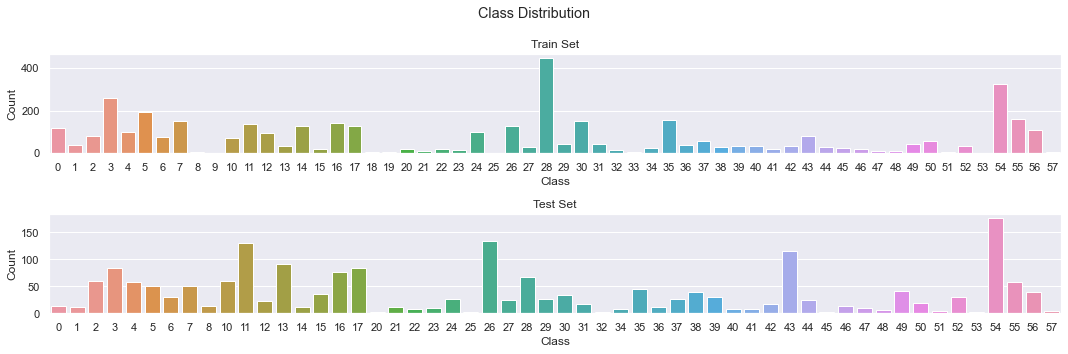

In [25]:
train_labels_counts = df_train['Labels'].value_counts().sort_index()
test_labels_counts = df_test['Labels'].value_counts().sort_index()

fig, ax = plt.subplots(2, 1)
ax = np.ravel(ax)

sns.barplot(x=train_labels_counts.index, y=train_labels_counts, ax=ax[0])
ax[0].set(
    ylabel='Count',
    xlabel='Class',
    title='Train Set'
)

sns.barplot(x=test_labels_counts.index, y=test_labels_counts, ax=ax[1])
ax[1].set(
    ylabel='Count',
    xlabel='Class',
    title='Test Set'
)

fig.set(
    figheight=5,
    figwidth=15
)
fig.suptitle('Class Distribution')
fig.tight_layout()
fig.savefig('visualizations/ClassDistributionBarGraph.png')

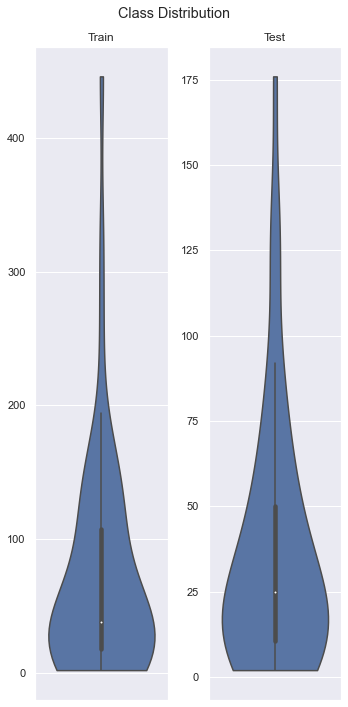

In [26]:
fig, ax = plt.subplots(1, 2)
sns.violinplot(data=df_train['Labels'].value_counts(), ax=ax[0], cut=0).set(
    xticks=[], title='Train'
    )
sns.violinplot(data=df_test['Labels'].value_counts(), ax=ax[1], cut=0).set(
    xticks=[], title='Test'
    )

fig.set(figheight=10, figwidth=5)
fig.suptitle('Class Distribution')
fig.tight_layout()

fig.savefig('visualizations/ClassDistributionsViolin.png')

## Top and Bottom 5 Images

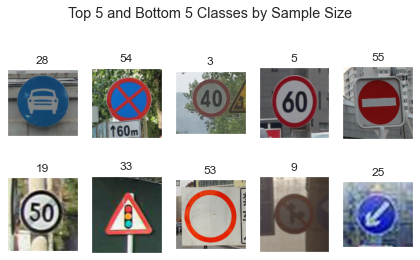

In [27]:
counts = df_train['Labels'].value_counts()
top5_idx = counts[0:5].index
bottom5_idx = counts[-5:len(counts)].index

top5_fnames = []
bottom5_fnames = []
for cat in top5_idx:
    fname = df_train[df_train['Labels'] == cat].iloc[0, 0]
    top5_fnames.append(fname)

for cat in bottom5_idx:
    fname = df_train[df_train['Labels'] == cat].iloc[0, 0]
    bottom5_fnames.append(fname)

fig, ax = plt.subplots(2, 5)
ax = ax.ravel()

for idx, fname in enumerate(top5_fnames):
    img_dir = os.path.join(train_dir, fname)
    with Image.open(img_dir) as img:
        ax[idx].imshow(img)
    ax[idx].set(
        title=top5_idx[idx],
        xticks=[],
        yticks=[]
    )

for idx, fname in enumerate(bottom5_fnames):
    img_dir = os.path.join(train_dir, fname)
    with Image.open(img_dir) as img:
        ax[idx+5].imshow(img)
    ax[idx+5].set(
        title=bottom5_idx[idx-5],
        xticks=[],
        yticks=[]
    )

fig.suptitle('Top 5 and Bottom 5 Classes by Sample Size')
fig.tight_layout()

## Classes with sample size < 50

Neural networks require a significant amount of data to train properly. Before preparing the dataset, it's important to know if there are any classes that are undersampled. What this threshold is can vary and will be part of testing to determine the minimum amount required for the neural network to learn. 

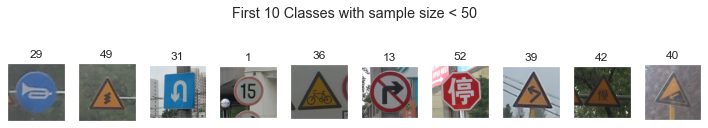

In [28]:
filter = df_train['Labels'].value_counts() <= 50
under_50 = df_train['Labels'].value_counts()[filter]

fig, ax = plt.subplots(1, 10)
ax = ax.ravel()
for i, idx in enumerate(under_50.index[0:10]):
    with Image.open(os.path.join(train_dir, df_train[df_train['Labels']==idx].iloc[0, 0])) as img:
        ax[i].imshow(img)
    ax[i].set(
        title=idx,
        xticks=[],
        yticks=[]
    )

fig.suptitle('First 10 Classes with sample size < 50', y=0.7)
fig.set(
    figheight=5,
    figwidth=10
)
fig.tight_layout()

## Checking for any missing classes between the test and train data

Unique Classes

In [29]:
unique_classes_test = df_test['Labels'].unique()
unique_classes_train= df_train['Labels'].unique()
missing_classes_train = [x for x in unique_classes_test if x not in unique_classes_train]
missing_classes_test = [x for x in unique_classes_train if x not in unique_classes_test]
missing_classes = np.concatenate([missing_classes_test, missing_classes_train])

print(f'Test missing classes relative to Train Set: {missing_classes_test}')
print(f'Train missing classes relative to Test Set: {missing_classes_train}')

Test missing classes relative to Train Set: [9, 18, 19, 33]
Train missing classes relative to Test Set: []


The missing classes are also in the list of classes with the lowest sample sizes. These classes will then be dropped during preprocessing. Furthermore, samplesizes less than 50 are much too low for any significant learning, so these classes will be dropped as well. For now, only the missing classes will be dropped.

In [30]:
to_drop_train = df_train[df_train['Labels'].isin(missing_classes)].index
to_drop_test = df_test[df_test['Labels'].isin(missing_classes)].index
df_train.drop(index=to_drop_train, inplace=True)
df_test.drop(index=to_drop_test, inplace=True)

## Verifying that label generation was done correctly

Text(0.5, 0.98, 'Verifying Image Labels')

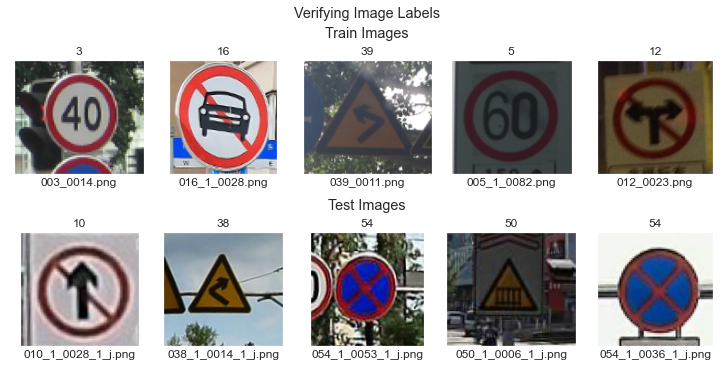

In [31]:
random_train_idx = np.random.randint(low=0, high=len(df_train), size=5)
random_test_idx = np.random.randint(low=0, high=len(df_test), size=5)

fig = plt.figure(constrained_layout=True)
fig.suptitle('Verifying Labels')

subfigs = fig.subfigures(2)

ax = subfigs[0].subplots(1, 5)
for idx, img_idx in enumerate(random_train_idx):
    img_fname = df_train['File Names'].iloc[img_idx]
    img_label = df_train['Labels'].iloc[img_idx]
    with Image.open(os.path.join(train_dir, img_fname)) as img:
        ax[idx].imshow(img)
    ax[idx].set(
        xticks=[],
        yticks=[],
        title=img_label,
        xlabel=img_fname
    )

ax = subfigs[1].subplots(1, 5)
for idx, img_idx in enumerate(random_test_idx):
    img_fname = df_test['File Names'].iloc[img_idx]
    img_label = df_test['Labels'].iloc[img_idx]
    with Image.open(os.path.join(test_dir, df_test['File Names'].iloc[img_idx])) as img:
        ax[idx].imshow(img)
    ax[idx].set(
        xticks=[],
        yticks=[],
        title=img_label,
        xlabel=img_fname
    )

subfigs[0].suptitle('Train Images')
subfigs[1].suptitle('Test Images')

fig.set(
    figwidth=10,
    figheight=5,
)
fig.suptitle('Verifying Image Labels')

## Ensuring all between the train and test set contain the same type of sign.

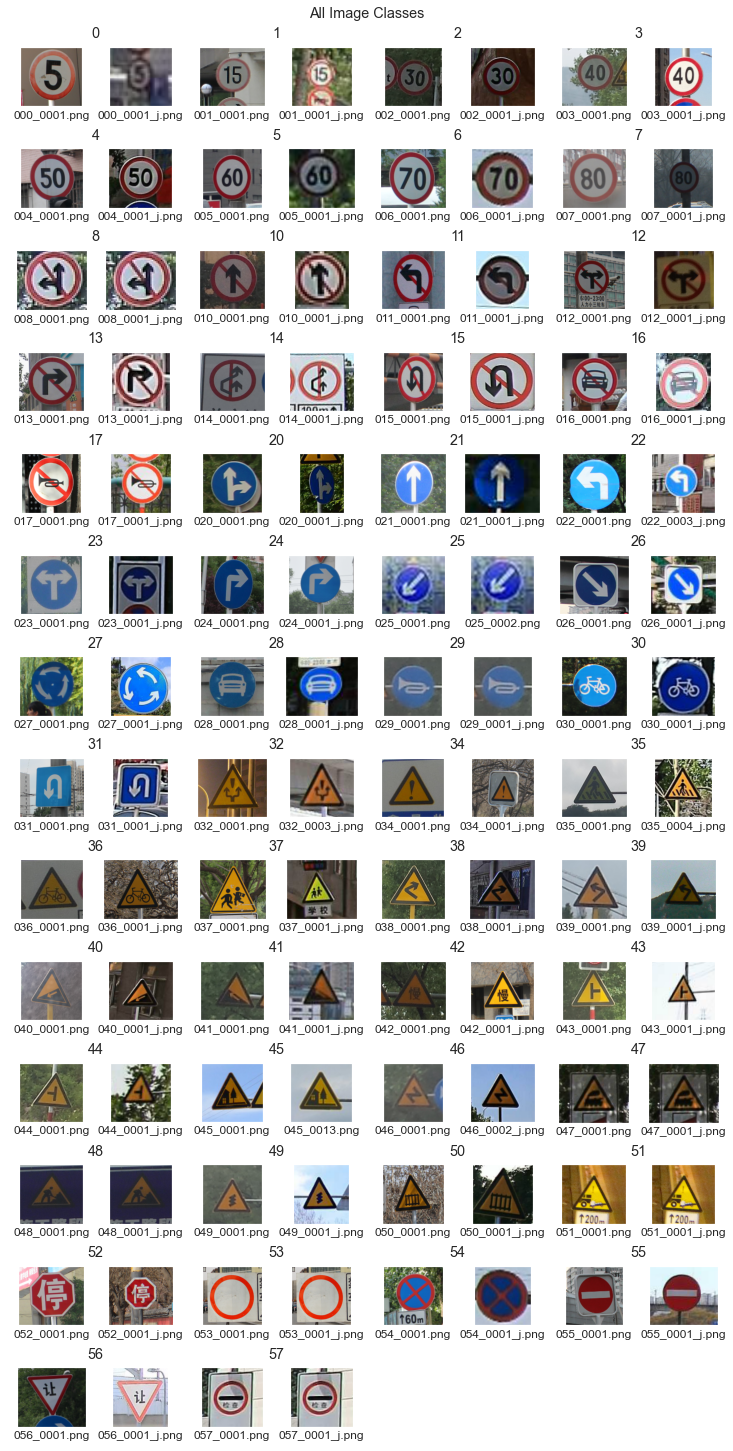

In [32]:
fig = plt.figure(constrained_layout=True)
fig.set(
    figwidth=10,
    figheight=20
)
subfigs = fig.subfigures(df_train['Labels'].nunique()//4+1, 4)
subfigs = np.ravel(subfigs)

for index, unique_class in enumerate(df_train['Labels'].unique()):
    subfig = subfigs[index]
    ax = subfig.subplots(1, 2)
    ax = np.ravel(ax)

    # For the Train Image
    label_filter = df_train['Labels'] == unique_class
    img_fname = df_train[label_filter]['File Names'].iloc[0]
    with Image.open(os.path.join(train_dir, img_fname)) as img:
        ax[0].imshow(img)
    ax[0].set(
        xticks=[],
        yticks=[],
        xlabel=img_fname
    )

    # For the Test Image
    label_filter = df_test['Labels'] == unique_class
    img_fname = df_test[label_filter]['File Names'].iloc[0]
    with Image.open(os.path.join(test_dir, img_fname)) as img:
        ax[1].imshow(img)
    ax[1].set(
        xticks=[],
        yticks=[],
        xlabel=img_fname
    )

    subfig.suptitle(unique_class)

fig.suptitle('All Image Classes')
fig.savefig('visualizations/ImageClasses.png')


## Image Sizes
It's important to determine the general distribution of the image sizes as the neural network can only be fitted and used on one image size, meaning the image sizes will be homogenized before training.

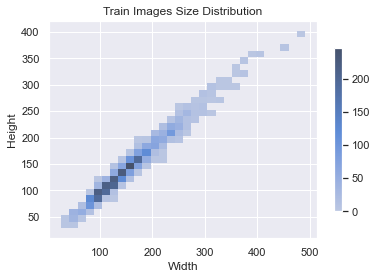

In [33]:
img_height, img_width = [], []
for fname in df_train['File Names']:
    with Image.open(os.path.join(train_dir, fname)) as img:
        img_height.append(img.height)
        img_width.append(img.width)

sns.histplot(
    data=zip(img_height, img_width), x=img_width, y=img_height,
    bins=30, cbar=True, cbar_kws=dict(shrink=.75)
    ).set(title='Train Images Size Distribution', xlabel='Width', ylabel='Height');

The heatmap above shows that most images are within the 150 range in height and width. There are a few variables that are smaller and some more that are bigger but these should easily be remedied with padding. The issue can come with images that are simply too big compared to the rest of the dataset. This is because, when cropping, it's hard to explicitly set which part of the image is the target or focus. This means that the image could be cropped on a part of the image that isn't that target. This project won't be tackling this, but it's important to be aware of this moving forward.